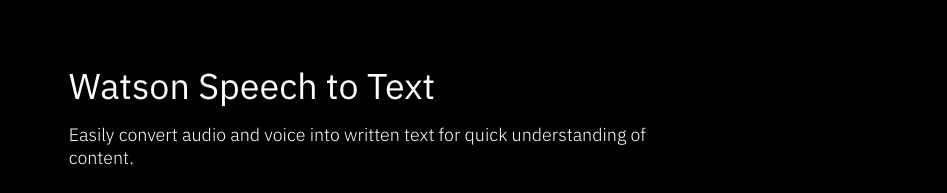

# Getting started with Speech to Text

The IBM® Speech to Text service provides APIs that use IBM's speech-recognition capabilities to produce transcripts of spoken audio. The service can transcribe speech from various languages and audio formats. In addition to basic transcription, the service can produce detailed information about many different aspects of the audio. For most languages, the service supports two sampling rates, broadband and narrowband. It returns all JSON response content in the UTF-8 character set.  

This notebook explains how to develop a custom-model for your chosen language

IBM documentation for Watson Speech to Text https://cloud.ibm.com/docs/speech-to-text?topic=speech-to-text-gettingStarted

IBM API documentation for Watson Speech to Text https://cloud.ibm.com/apidocs/speech-to-text?code=python#introduction


Thanks to @kchallapalli for some of the code in the notebook

## Before you begin

a) Create an instance of the service:
<br>
b) Go to the Speech to Text page in the IBM Cloud Catalog. select Watson Speech to Text (STT)
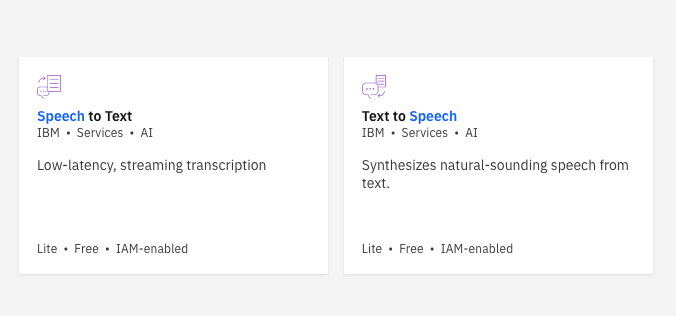

c) Select your Region + Plan and Click Create.
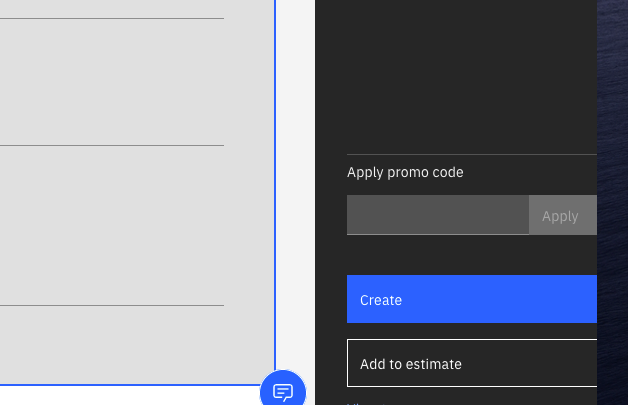

d) Copy the credentials to authenticate to your service instance:
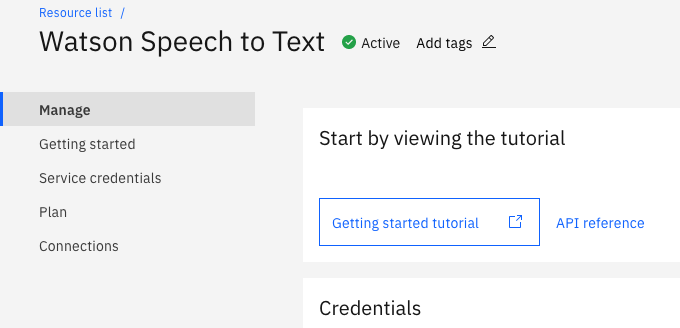

e) From the IBM Cloud Resource list, click on your Speech to Text service instance to go to the Speech to Text service dashboard page.
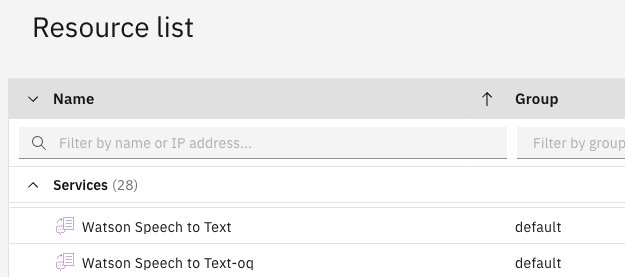


## 1. Setup

##### To prepare your environment, you need to install some packages and enter credentials for the Watson services.

In [ ]:
!pip install jiwer
!pip install --upgrade "ibm-watson>=4.4.0"
!pip install pandas

### 1.1 Import Packages and Libraries

In [ ]:
from ibm_watson import SpeechToTextV1
from jiwer import wer
import pandas as pd
import os
from os.path import join, dirname, abspath
import time
import json
import io
import sys
import csv



### 1.2 Creating a local path for your notebook


In [ ]:
notebook_path = os.path.dirname(os.path.abspath("STT Language model.ipynb"))

### 1.3 Add Service Credentials From IBM Cloud for Watson Services

#### Edit the following cell to provide your credentials for Watson STT

Insert API keys and URLs in the following cell.
Run the cell.


In [ ]:
url = "<insert your url information>"
api_key = "<insert your apikey information>"
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
authenticator = IAMAuthenticator(api_key)
speech_to_text = SpeechToTextV1(
authenticator=authenticator
    )
speech_to_text.set_service_url(url)

## 2. Create a new language model in Watson STT

### For most languages, the service supports both broadband and narrowband models:

Broadband models are for audio that is sampled at greater than or equal to 16 kHz. Use broadband models for responsive, real-time applications, for example, for live-speech applications.
<br>

Narrowband models are for audio that is sampled at 8 kHz. Use narrowband models for offline decoding of telephone speech, which is the typical use for this sampling rate.


### 2.1 List the speech model available within the Watson STT service

In [ ]:
speech_models = speech_to_text.list_models().get_result()
print(json.dumps(speech_models, indent=2))

### 2.2 List the speech custom language models available within your Watson STT service

You create a custom language model and add corpora and words specific to your domain. Once you train the custom language model on your enhanced vocabulary, you can use it for customized speech recognition. The service can typically train any custom model in a matter of minutes. The level of effort that it takes to create a model depends on the data that you have available for the model.

In [ ]:
language_models = speech_to_text.list_language_models().get_result()
print(json.dumps(language_models, indent=2))

### 2.2 Create a speech custom language models available within your Watson STT service 

- add a name for the language model in the cell below
- add the language and type of base model in the cell below example : ***nl-NL_NarrowbandModel / nl-NL_BroadbandModel***
- provide a description of the model

In [ ]:
language_model = speech_to_text.create_language_model(
		'<add your name of the model>',
		'<add your language model>',
		description = '<provide a description>'
	).get_result()
print(json.dumps(language_model, indent=2))

### 2.3 Add the "customization_id" from the output above to the cell below.

In [ ]:
customization_id = "<customizstion_id>"

## 3. Upload your "corpora into Watson STT

Corpora: The recommended means of populating a custom language model with words is to add one or more corpora to the model. When you add a corpus, the service analyzes the file and automatically adds any new words that it finds to the custom model. Adding a corpus to a custom model allows the service to extract domain-specific words in context, which helps ensure better transcription results. For more information, see Working with Corpora. https://cloud.ibm.com/docs/speech-to-text?topic=speech-to-text-corporaWords#workingCorpora


### 3.1 List the "corpora" within your language model


In [ ]:
corpora = speech_to_text.list_corpora(customization_id).get_result()
print(json.dumps(corpora, indent=2))

### 3.2 Provide a name for the corpus in the cell below

In [ ]:
corpus_name = "<add you name>"

### 3.3 Place your training data into "in/corpus.txt", must be UTF-8 encoded!

In [ ]:
corpus_path = notebook_path + os.sep + 'in' + os.sep + 'corpus.txt'

with open(corpus_path, 'rb') as corpus_file:  
    speech_to_text.add_corpus(
        customization_id,
        corpus_name,
        corpus_file,
        allow_overwrite=True
    )

## 4. Add individual custom words to the model directly

Although adding corpora is the recommended means of adding words to a custom language model, you can also add individual custom words to the model directly. The service adds the custom words to the custom model just as it does OOV words that it discovers from corpora.

If you have only one or a few words to add to a model, using corpora to add the words might not be practical or even viable. The simplest approach is to add a word with only its spelling. But you can also provide multiple pronunciations for the word and indicate how the word is to be displayed.

This link provides information about working with corpora and custom words
https://cloud.ibm.com/docs/speech-to-text?topic=speech-to-text-corporaWords

### 4.1 List the "custom-words" within your language model

In [ ]:
words = speech_to_text.list_words(customization_id).get_result()
print(json.dumps(words, indent=2))

### 4.1 Add "custom-words" directly into your language model


The words resource includes all words that you add from corpora, from grammars, or directly. Its purpose is to define the pronunciation and spelling of words that are not already present in the service's base vocabulary. The definitions tell the service how to transcribe these out-of-vocabulary (OOV) words. The words resource contains the following information about each OOV word. The service creates the definitions for words that are extracted from corpora and grammars. You specify the characteristics for words that you add or modify directly.

**word**: The spelling of the word as found in a corpus or grammar or as added by you.

**sounds_like**: The pronunciation of the word. For words extracted from corpora and grammars, the value represents how the service believes that the word is pronounced based on its language rules. In many cases, the pronunciation reflects the spelling of the word field.

**display_as**: The spelling of the word that the service uses in transcripts. The field indicates how the word is to be displayed. In most cases, the spelling matches the value of the word field.

**source**: How the word was added to the words resource. If the service extracted the word from a corpus or grammar, the field lists the name of that resource. Because the service can encounter the same word in multiple resources, the field can list multiple corpus or grammar names. The field includes the string user if you add or modify the word directly.

***Replace the NCAA example below with your custom words***

In [ ]:
speech_to_text.add_word(
    (customization_id),
    'NCAA',
    sounds_like=['N. C. A. A.', 'N. C. double A.'],
    display_as='NCAA'
)



### 4.2 Gets information about a custom word from a custom language 

Replace the NCAA example below with your custom words


In [ ]:
word = speech_to_text.get_word(
    (customization_id),
    'NCAA'
).get_result()
print(json.dumps(word, indent=2))

### 4.3 Delete a custom word from a custom language 

Delete a custom word from a custom language model. You can remove any word that you added to the custom model's words resource via any means. However, if the word also exists in the service's base vocabulary, the service removes only the custom pronunciation for the word; the word remains in the base vocabulary. Removing a custom word does not affect the custom model until you train the model with the Train a custom language model method

***Replace the NCAA example below with your custom words***

In [ ]:
speech_to_text.delete_word(
    (customization_id),
    'NCAA'
)

## 5. Add "grammar" to the model directly

A grammar uses a formal language specification to define a set of production rules for transcribing strings. The rules specify how to form valid strings from the language's alphabet. When you apply a grammar to speech recognition, the service can return only one or more of the phrases that are generated by the grammar. For example, when you need to recognize specific words or phrases, such as yes or no, individual letters or numbers, or a list of names, using grammars can be more effective than examining alternative words and transcripts. Moreover, by limiting the search space for valid strings, the service can deliver results faster and more accurately.

This link the information about adding a grammar to the custom language model https://cloud.ibm.com/docs/speech-to-text?topic=speech-to-text-grammarAdd#addGrammar

### 5.1 List the "grammar" within your language model

In [ ]:
grammars = speech_to_text.list_grammars(customization_id).get_result()
print(json.dumps(grammars, indent=2))

### 5.2 Provide a name for the grammar in the cell below

The name of the new grammar for the custom language model. Use a localized name that matches the language of the custom model and reflects the contents of the grammar.

The name of the new grammar for the custom language model. Use a localized name that matches the language of the custom model and reflects the contents of the grammar.

a) Include a maximum of 128 characters in the name.
<br>
b) Do not use characters that need to be URL-encoded. For example, do not use spaces, slashes, backslashes, colons, ampersands, double quotes, plus signs, equals signs, questions marks, and so on in the name. (The service does not prevent the use of these characters. But because they must be URL-encoded wherever used, their use is strongly discouraged.)
<br>
c)Do not use the name of an existing grammar or corpus that is already defined for the custom model.
<br>
d)Do not use the name user, which is reserved by the service to denote custom words that are added or modified by the user.
<br>
e)Do not use the name base_lm or default_lm. Both names are reserved for future use by the service.



In [ ]:
grammar_name = "<add you name>"

### 5.3 Add grammar directly into your language model
To add a grammar that has the same name as an existing grammar, set the ***allow_overwrite parameter to true***

- Place your grammar file in the "in" directory
- Add your grammar_name to the cell below

In [ ]:
grammar_file = "<add your name grammar file>"
grammar_path = notebook_path + os.sep + 'in' + os.sep + grammar_file
with open(grammar_path, 'rb') as grammar_file:
    speech_to_text.add_grammar(
        customization_id,
        "<grammar_name>",
        grammar_file,
        'application/srgs', #for augmented backus naur form
        allow_overwrite=True
    )

### 5.4 Gets information about the grammar from a custom language 

Gets information about a grammar from a custom language model. The information includes the total number of out-of-vocabulary (OOV) words, name, and status of the grammar. 

In [ ]:
grammar = speech_to_text.get_grammar(
    (customization_id),
    (grammar_name),
).get_result()
print(json.dumps(grammar, indent=2))

### 5.5 Deletes grammar from a custom language 

Deletes an existing grammar from a custom language model. The service removes any out-of-vocabulary (OOV) words associated with the grammar from the custom model's words resource unless they were also added by another resource or they were modified in some way with the Add custom words or Add a custom word method. Removing a grammar does not affect the custom model until you train the model with the Train a custom language model method. You must use credentials for the instance of the service that owns a model to delete its grammar.

In [ ]:
speech_to_text.delete_grammar(
   (customization_id),
    (grammar_name),
)

## 6. Train your Watson STT custom language

Initiates the training of a custom language model with new resources such as corpora, grammars, and custom words. After adding, modifying, or deleting resources for a custom language model, use this method to begin the actual training of the model on the latest data. You can specify whether the custom language model is to be trained with all words from its words resource or only with words that were added or modified by the user directly. You must use credentials for the instance of the service that owns a model to train it.

The training method is asynchronous. It can take on the order of minutes to complete depending on the amount of data on which the service is being trained and the current load on the service. 

In [ ]:
speech_to_text.train_language_model(customization_id)

### 6.1 Retrieves the status of the custom model training. The status must be "available" to proceed

In [ ]:
language_models = speech_to_text.list_language_models().get_result()
print(json.dumps(language_models, indent=2))

## 7. Test your WER using the custom model of Watson STT

Place your test sentances within the "reference.txt" file located in the "in" directory. The order of the test sentances need to match the order of the audio files you will input below.

In [ ]:
with open (notebook_path + os.sep + 'in' + os.sep + 'reference.txt', 'r', encoding='utf8') as file:
    references = file.readlines()
    
references = [x.rstrip() for x in references]
references = [x.strip("?") for x in references]
print(references)

### 7.1 Add audio to the "audio" folder within the "in" directory

(The files must be in the same order as the reference.txt file) 

##### Why customization weight are key to your results

A custom language model is a combination of the custom model and the base model that it customizes. You can tell the service how much weight to give to words from the custom language model compared to words from the base model for speech recognition. The weight that is assigned to a custom model is referred to as its ***customization weight***. You specify the relative weight for a custom language model as a double between 0.0 to 1.0. By default, each custom language model has a weight of 0.3. The default weight yields the best performance in the general case. It allows both OOV words from the custom model and words from the base vocabulary to be recognized.

This link provides more informtion about "customization weight" https://cloud.ibm.com/docs/speech-to-text?topic=speech-to-text-languageUse#weight

***Please note: Add your 'acoustic_cutomization_id' if you have completed your "acoustic training" more information about acoustic training can be found at this link :https://cloud.ibm.com/docs/speech-to-text?topic=speech-to-text-acoustic ***

- add audio format, see information in the link about formats - https://cloud.ibm.com/docs/speech-to-text?topic=speech-to-text-audio-formats#formats
- add language model type 
- add grammar name


In [ ]:
test_set_path = notebook_path + os.sep + 'in'+ os.sep + 'audios'

files = []
results = []

for audio_file_name in os.listdir(test_set_path):
    if audio_file_name.endswith(".wav"):
        files.append(test_set_path + os.sep + audio_file_name)
        
files.sort()        
for file in files:
    print("Processing: " + file)
    with open(file, 'rb') as audio_file:
        speech_recognition_results = speech_to_text.recognize(
            audio=audio_file
            ,content_type='audio/<add audio format>'
            ,model= '<add language model type>'
            ,customization_id= customization_id
            ,customization_weight=0.3
            ,max_alternatives=3
            ,grammar_name= '<add grammar name>'
            # ,acoustic_customization_id="<acoustic_cutomization_id>"
        ).get_result()
    
    results.append(speech_recognition_results.get("results")[0].get("alternatives")[0].get('transcript'))
    print(json.dumps(speech_recognition_results.get("results"), indent=2))


### 7.2 Your results are printed below


In [ ]:
print(results)

### 7.3 Execute the cell below to export your results to .CSV

The CSV file can be found in the "out" directory


In [ ]:
wers = pd.DataFrame(columns=['Input File', 'Reference', 'Transcript', 'WER'])
for i in range(len(references)):
    error = wer(references[i], results[i])
    wers = wers.append(
        {'Input File' : files[i].split(os.sep)[-1], 
         'Reference' : references[i], 
         'Transcript' : results[i], 
         'WER' : error}, ignore_index=True)
    
wers.head()
wer_output_path = notebook_path + os.sep + 'out' + os.sep + 'wer-' + str(time.time()) + '.csv'
export_csv = wers.to_csv (wer_output_path, index = None, header=True, encoding="utf-8")
print("Word Error Rates are saved as .csv in the out-folder!\n")
print("Overall Error: " + str(wer(references, results)))

## 8. Danger zone - delete your custom model 

In [ ]:
customizations = language_models["customizations"]
for customization in customizations:
	id = customization["customization_id"]
	print("deleting customization:", id)
	speech_to_text.delete_language_model(id)